In [1]:
from netgen.geom2d import SplineGeometry
from ngsolve import *
from ngsolve.internal import *
from xfem import *
from xfem.lsetcurv import *
import numpy as np
import math
import tikzplotlib
import matplotlib.pyplot as plt

importing NGSolve-6.2.2104
importing ngsxfem-2.0.dev


In [2]:
order = 3 # fixed for now

square = SplineGeometry()
square.AddRectangle((-1, -1), (1, 1), bc=1)
ngmesh = square.GenerateMesh(maxh=00.85)
#ngmesh = square.GenerateMesh(maxh=00.5)
mesh = Mesh(ngmesh)
#Draw(mesh)

 Generate Mesh from spline geometry
 Boundary mesh done, np = 8
 CalcLocalH: 8 Points 0 Elements 0 Surface Elements
 Meshing domain 1 / 1
 load internal triangle rules
 Surface meshing done
 Edgeswapping, topological
 Smoothing
 Split improve
 Combine improve
 Smoothing
 Edgeswapping, metric
 Smoothing
 Split improve
 Combine improve
 Smoothing
 Edgeswapping, metric
 Smoothing
 Split improve
 Combine improve
 Smoothing
 Update mesh topology
 Update clusters


In [3]:
#Draw(lsetmeshadap.lset_p1, mesh, "lsetp1", min=0, max=0)

In [4]:
r = sqrt(x**2 + y**2)
levelset = r - 0.8

In [5]:
lsetmeshadap = LevelSetMeshAdaptation(mesh, order=order, threshold=0.1)
deformation = lsetmeshadap.CalcDeformation(levelset)
deformedcoords = CoefficientFunction((x,y)) + deformation

setvalues element 14/14                                 
setvalues element 14/14                                 
project shift on element 14/14                                 


In [6]:
class BbezShapeControl:
   
	def __init__(self, mesh, deformation):
		self.mesh = mesh
		self.deformation = deformation
		self.min_angle = None
		self.max_angle = None
		return

	def Update(self):
		"""Compute Bezier-Points of the deformed mesh"""
		n_elm=self.mesh.ne
		og = self.deformation.space.globalorder
		def BernsteinTrig(x, y, i, j, n):
			return math.factorial(n)/math.factorial(i)/math.factorial(j)/math.factorial(n-i-j)* x**i*y**j*(1-x-y)**(n-i-j)
		ndtrig = int((og+1)*(og+2)/2)
		Bvals = Matrix(ndtrig, ndtrig)
		ii = 0
		for ix in range(og+1):
			for iy in range(og+1-ix):
				jj = 0
				for jx in range(og+1):
					for jy in range(og+1-jx):
							Bvals[ii,jj] = BernsteinTrig(ix/og, iy/og, jx, jy, og)
							jj += 1
				ii += 1
		iBvals_trig = Bvals.I
		ipts = [(i/og,j/og) for j in range(og+1) for i in range(og+1-j)]
		deformedcoords = CoefficientFunction((x,y)) + self.deformation
		ir_trig = IntegrationRule(ipts, [0,]*len(ipts))
		pts = self.mesh.MapToAllElements({ET.TRIG: ir_trig}, VOL)
		pmat = deformedcoords(pts)
		pmat = pmat.reshape(-1, len(ir_trig), 2)
		BezierPnts = np.tensordot(iBvals_trig.NumPy(), pmat, axes=(1,1))
		return BezierPnts

	def Draw2d(self):
		"""Plot Bezier control grid"""
		n_elm=self.mesh.ne
		og = self.deformation.space.globalorder
		BezierPnts = self.Update()        
		lvl = [0 for i in range(og+1)]
		idx = [i for i in range(n_elm)]
		j=0
		for i in range(og+1):
			lvl[og-i]=idx[j:j+og+1-i] 
			j+=len(lvl[og-i])
		p=[]
		for i in range(og):
			for l in lvl[og-i]:
				p.append(l)
			p.append(lvl[og-i-1][-1])
			for k in range(len(lvl[og-i-1])-1):
				p.append(lvl[og-i][-2-k])
				if k != og-i-2:
					p.append(lvl[og-i-1][-2-k])
		for i in range(1,og+1):
			p.append(lvl[i][0])
		for q in range(BezierPnts.shape[1]):
			plt.plot(BezierPnts[p,q,0],BezierPnts[p,q,1], marker = 'o')
		return

	def Draw(self):
		"""Draw control grid """
		if self.mesh.dim==2: self.Draw2d()
		else: print("Zukunftsmusik")
		return("dim error")

	def ComputeAngles(self): 
		"""Calculate the angles of the triangles in the control grid for all elements"""
		BezierPnts = self.Update()   
		og = self.deformation.space.globalorder
		n_tri=int((og)*(og+1)/2)
		n_elm=self.mesh.ne
		triangles=np.zeros(2*3*n_elm*n_tri).reshape([n_elm,n_tri,3,2])
		for elm in range(n_elm):
			j=0
			n=0
			for l in range(og+1):
				for i in range(og-l):
					for k in range(2):
						triangles[elm,n,0,k]=BezierPnts[j,elm][k]
						triangles[elm,n,1,k]=BezierPnts[j+1,elm][k]
						triangles[elm,n,2,k]=BezierPnts[j+1+og-l,elm][k]
					j+=1
					n+=1
				j+=1
		angles = np.zeros(triangles.shape[0]*n_tri*3).reshape([BezierPnts.shape[1],n_tri,3])
		for elm in range(triangles.shape[0]):
			for tri in range(n_tri): 
				a = math.sqrt(sum((triangles[elm,tri,1,i]-triangles[elm,tri,2,i])**2 for i in range(2)))
				b = math.sqrt(sum((triangles[elm,tri,0,i]-triangles[elm,tri,2,i])**2 for i in range(2)))
				c = math.sqrt(sum((triangles[elm,tri,0,i]-triangles[elm,tri,1,i])**2 for i in range(2)))
				alpha = math.acos((b**2+c**2-a**2)/(2*b*c))
				beta = math.acos((a**2+c**2-b**2)/(2*a*c))
				gamma = math.acos((a**2+b**2-c**2)/(2*a*b))
				angles[elm,tri]=[math.degrees(alpha),math.degrees(beta),math.degrees(gamma)]
		return angles

	def MinAngles(self):
		"""Return minimal angle for each element"""
		og = self.deformation.space.globalorder
		n_tri=int((og)*(og+1)/2)
		angles = self.ComputeAngles()
		min_angle=np.zeros(angles.shape[0])
		for elm in range(angles.shape[0]):
			min_angle[elm] = min(angles[elm].reshape(n_tri*3))
		self.min_angle = min_angle
		return None

	def MaxAngles(self):
		"""Return maximal angle for each element"""
		og = self.deformation.space.globalorder
		n_tri=int((og)*(og+1)/2)
		angles = self.ComputeAngles()
		max_angle=np.zeros(angles.shape[0])
		for elm in range(angles.shape[0]):
			max_angle[elm] = max(angles[elm].reshape(n_tri*3))
		self.max_angle=max_angle
		return max_angle

	def DrawMeshToTikz(self, file_name):
		"""Write file with LaTeX-code for inclusion of the control grid plot with Tikz"""
		tikzplotlib.save(file_name)
		return
#def Admissible(minangle, maxangle):
#	return

#def Adjust():
#	return


[ 90.2588322   90.71198829  86.90759475 109.54193685  90.25682812
  90.71257719  86.9068509  109.54288896  73.66073654  97.04048079
  73.66137144  97.03777438 114.76436195 114.7619415 ]


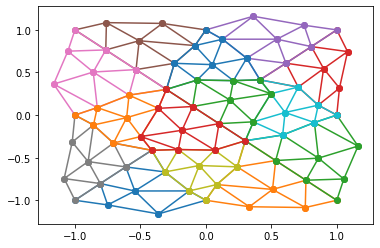

In [9]:
#import bbezmodule_current

bbez = BbezShapeControl(mesh,deformation)
bbez.Update() # deformation.space.globalorder, mesh.dim 

bbez.Draw() #matplotlib

#does all the magic
bbez.ComputeAngles()

#return min/max angles per element
minangles = bbez.MinAngles()
maxangles = bbez.MaxAngles()

#return true/false - array
#ba_acceptable = bbez.Admissible(minangle, maxangle)

# deformation is adjusted until acceptable
#bbez.Adjust()

#bbez.DrawMeshToTikz("mesh.tex")
print(maxangles)